# Optimization using hyperopt and BaysianOptimization

Common imports for all sections.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Function to optimize

Define the function to minimize.

In [26]:
def function(x, y):
    x0, y0 = 1.2, 0.7
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    return 1.0 - np.abs(np.cos(2.0*np.pi*r))*np.exp(-r)

Visualize the function.

In [27]:
x = np.linspace(-3.0, 3.0, 101)
y = np.linspace(-3.0, 3.0, 101)
X, Y = np.meshgrid(x, y)
data = function(X, Y)

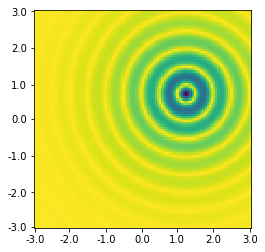

In [33]:
_ = plt.imshow(data, origin='lower')
_ = plt.xticks(np.linspace(0, 100, 7, dtype=np.int), np.linspace(-3.0, 3.0, 7))
_ = plt.yticks(np.linspace(0, 100, 7, dtype=np.int), np.linspace(-3.0, 3.0, 7))

## hyperopt

Required imports.

In [69]:
from hyperopt import fmin, hp, rand, STATUS_OK, tpe, Trials
from hyperopt.pyll.stochastic import sample
import time

### Sample space

Define the optimization space.  The two parameters are $x$ and $y$, and the sample points should be uniformly distributed in the intervals $x \in [-3, 3]$ and $y \in [-3, 3]$.

In [34]:
space = (hp.uniform('x', -3.0, 3.0), hp.uniform('y', -3.0, 3.0))

We can sample the space using the `sample` method, e.g.,

In [35]:
for _ in range(5):
    print(sample(space))

(1.0403709017839784, -0.21788172564365027)
(-2.3826235075838222, -0.039939957006174254)
(1.0698764523317807, 0.7923260433783819)
(-0.6925704547626408, 2.6733156214633276)
(0.245348672280417, -2.12328721680659)


### Objective function

The `sample` function returns tuples of $x$ and $y$ values, so the obje ctive function should take a tuple as argument.  Having a dictionary as a return type, rather than simply the value makes it easier to retrieve information from the `Trials` object that can be passed to `fmin`.

In [44]:
def objective(values):
    return {
        'loss': function(values[0], values[1]),
        'x': values[0], 'y': values[1],
        'status': STATUS_OK, 'time': time.time(),
    }

A `Trials` object keeps track of the optimization process, so that it can be visualized or otherwise inspected when the optimization is done.

### Trials

Define a function that takes a `Trial` object, and returns two numpy arrays with the $x$ and $y$ coordinates of the sample points.

In [63]:
def sample_trace(trials):
    x = np.empty(len(trials))
    y = np.empty(len(trials))
    for i, result in enumerate(trials.results):
        x[i] = result['x']
        y[i] = result['y']
    return x, y

### Tree of Parzen estimators (TPE)

In [45]:
trials = Trials()

In [46]:
best = fmin(objective, max_evals=100, space=space,
            algo=tpe.suggest, trials=trials)

In [47]:
print(best['x'], best['y'])

1.1425652199358358 0.6530828043733425


In [64]:
sample_x, sample_y = sample_trace(trials)

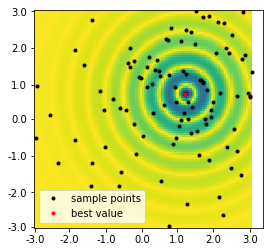

In [68]:
def scale(z):
    return (3.0 + z)*101.0/6.0

_ = plt.imshow(data, origin='lower')
_ = plt.plot(scale(sample_x), scale(sample_y), 'k.', label='sample points')
_ = plt.plot((scale(best['x']), ), (scale(best['y']), ), 'r.', label='best value')
_ = plt.xticks(np.linspace(0, 100, 7, dtype=np.int), np.linspace(-3.0, 3.0, 7))
_ = plt.yticks(np.linspace(0, 100, 7, dtype=np.int), np.linspace(-3.0, 3.0, 7))
_ = plt.legend()

### Random search

In [70]:
trials = Trials()

In [72]:
best = fmin(objective, max_evals=100, space=space,
            algo=rand.suggest, trials=trials)

In [73]:
print(best['x'], best['y'])

1.186179104951215 0.7094035143659889


In [74]:
sample_x, sample_y = sample_trace(trials)

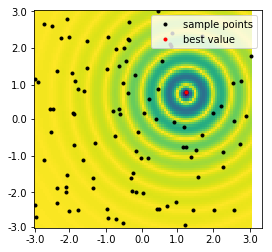

In [75]:
def scale(z):
    return (3.0 + z)*101.0/6.0

_ = plt.imshow(data, origin='lower')
_ = plt.plot(scale(sample_x), scale(sample_y), 'k.', label='sample points')
_ = plt.plot((scale(best['x']), ), (scale(best['y']), ), 'r.', label='best value')
_ = plt.xticks(np.linspace(0, 100, 7, dtype=np.int), np.linspace(-3.0, 3.0, 7))
_ = plt.yticks(np.linspace(0, 100, 7, dtype=np.int), np.linspace(-3.0, 3.0, 7))
_ = plt.legend()

Although both the TPE and random search found the global optimum, it is clear that the TPE algorithm samples the parameter space in a more intelligent way.

### Parameter space with choices

The space below represents the parameter space for an OpenMP parallel for loop schedule (static, dynamic or guided) and the chunck size for each.

In [106]:
space = hp.choice('schedule', [
    ('static', hp.qloguniform('chunk', 2, 11, 10)),
    ('dynamics', hp.qloguniform('chunk', 2, 11, 10)),
    ('guided', hp.qloguniform('chunk', 2, 11, 10)),
])

In [107]:
for _ in range(5):
    print(sample(space))

('dynamics', 4980.0)
('static', 630.0)
('guided', 30.0)
('dynamics', 5500.0)
('static', 20.0)


## BaysianOptimizer

Required imports.

In [76]:
from bayes_opt import BayesianOptimization

Define the objective function.

In [83]:
def objective(x, y):
    return -function(x, y)

In [84]:
param_bounds = {'x': (-3.0, 3.0), 'y': (-3.0, 3.0)}

In [91]:
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=1234)

In [92]:
optimizer.maximize(n_iter=100, init_points=3)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        | -0.9551   | -1.851    |  0.7327   |
|  2        | -0.8939   | -0.3736   |  1.712    |
|  3        | -0.9122   |  1.68     | -1.364    |
|  4        | -0.9527   |  3.0      |  3.0      |
|  5        | -0.998    | -3.0      |  3.0      |
|  6        | -0.9887   | -0.6269   | -3.0      |
|  7        | -0.9877   |  3.0      | -3.0      |
|  8        | -0.6267   |  1.375    |  0.9888   |
|  9        | -0.997    | -3.0      | -3.0      |
|  10       | -0.9427   |  3.0      |  0.5445   |
|  11       | -0.969    |  1.185    |  3.0      |
|  12       | -0.7355   |  0.3383   |  0.01111  |
|  13       | -0.9873   |  1.3      |  0.4737   |
|  14       | -0.9889   | -3.0      | -0.9207   |
|  15       | -0.9593   | -0.9858   | -1.173    |
|  16       | -0.9924   |  1.188    | -3.0      |
|  17       | -0.7917   |  2.196    |  1.873    |
|  18       | -0.997    |  3.0      | -1.389    |


|  100      | -0.8698   |  3.0      |  0.01539  |
|  101      | -0.9498   | -1.711    |  1.384    |
|  102      | -0.799    | -0.1246   | -0.1077   |
|  103      | -0.98     |  2.597    | -2.636    |


In [95]:
best = optimizer.max

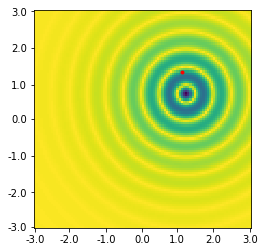

In [96]:
def scale(z):
    return (3.0 + z)*101.0/6.0

best_x = best['params']['x']
best_y = best['params']['y']
_ = plt.imshow(data, origin='lower')
_ = plt.plot((scale(best_x), ), (scale(best_y), ), 'r.', label='best value')
_ = plt.xticks(np.linspace(0, 100, 7, dtype=np.int), np.linspace(-3.0, 3.0, 7))
_ = plt.yticks(np.linspace(0, 100, 7, dtype=np.int), np.linspace(-3.0, 3.0, 7))